### Lecture 21 Markov chain Monte Carlo methods for Uncertainty Quantification (Introduction)

## Objectives

+ Objective 1: Why MCMC is needed ?
+ Objective 2: How to construct a MCMC sampler ?
+ Objective 3: How to tune the MCMC sampler ?

## Readings


+ For Monte Carlo:
    + Brian D. Ripley (2009). Stochastic Simulation
+ For Markov chain Monte carlo
    + Christian P. Robert and George Casella (2004). Monte Carlo Statistical Methods (Sections 6,8,9), OR..
    + Brooks et. al. (2011). Handbook of Markov Chain Monte Carlo (Chapter 1)
+ For software (Python, pyMC) 
    + Cameron Davidson-Pilon (2015). Probabilistic Programming and Bayesian Methods for Hackers 
        + ... there are several examples for practice 

# Why do we need, Markov chain Monte Carlo (MCMC) ???

![](slides_mcmc_1/slides-1.png)

![](slides_mcmc_1/slides-2.png)

## Application: Challenger Space Shuttle disaster


STORY: On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend.

QUESTION: At specific temperature, what is the probability of a damage incident? 


In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pymc as pm
from ipywidgets import interactive

In [2]:
# =============================
# Auxiliary functions required
# =============================

def myacorr(x) :
    mean_x = x.mean()
    z = np.fft.fft( x-mean_x, int(2**np.ceil( np.log2(2*x.size) ))+1 )
    z = z.real**2 + z.imag**2
    z = np.fft.ifft( z ).real
    z = z[:x.size]
    z = z/z[0]
    return z

# from __future__ import division, absolute_import, print_function
from scipy.linalg import toeplitz

def iat(x):
    r"""Estimate the integrated autocorrelation time, :math:`\tau_{int}` of a
    time series.
    
    This method estimates the spectral density at zero frequency by fitting
    an AR(p) model, with p selected by AIC.
    
    Parameters
    ----------
    x : ndarray, shape=(n_samples, n_dims)
        The time series, with time along axis 0.
    
    References
    ----------
    .. [1] Plummer, M., Best, N., Cowles, K., and Vines, K. (2006). CODA:
        Convergence diagnosis and output analysis for MCMC. R News, 6(1):7-11.
    
    Returns
    -------
    tau_int : ndarray, shape=(n_dims,)
        The estimated integrated autocorrelation time of each dimension in
        ``x``, considered independently.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    process_var = np.var(x, axis=0, ddof=1)
    
    tau_int = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        # fit an AR(p) model, with p selected by AIC
        rho, sigma2 = yule_walker(x[:,j], order_max=10)
        # power spectral density at zero frequency
        spec0 = sigma2 / (1 - np.sum(rho))**2
        # divide by the variance
        tau_int[j] = spec0 / process_var[j]
    
    return tau_int

def yule_walker(X, aic=True, order_max=None, demean=True):
    """Estimate AR(p) parameters from a sequence X using Yule-Walker equation.
    
    Parameters
    ----------
    X : array-like
        1d array
    aic: bool
        If ``True``, then the Akaike Information Criterion is used to choose
        the order of the autoregressive model. If ``False``, the model of order
        ``order.max`` is fitted.
    order_max : integer, optional
        Maximum order of model to fit. Defaults to the smaller of N-1 and
        10*log10(N) where N is the length of the sequence.
    demean : bool
        True, the mean is subtracted from `X` before estimation.
    
    Returns
    -------
    rho : array, shape=(order,)
        The autoregressive coefficients
    sigma2 : float
        Variance of the nosie term
    aic : float
        Akaike Information Criterion
    """
    # this code is adapted from https://github.com/statsmodels/statsmodels.
    # changes are made to increase compability with R's ``ar.yw``.
    X = np.array(X)
    if demean:
        X -= X.mean()
    n = X.shape[0]
    
    if X.ndim > 1 and X.shape[1] != 1:
        raise ValueError("expecting a vector to estimate AR parameters")
    
    if order_max is None:
        order_max = min(n - 1, int(10 * np.log10(n)))
    
    r = np.zeros(order_max+1, np.float64)
    r[0] = (X**2).sum() / n
    
    for k in range(1, order_max+1):
        r[k] = (X[0:-k]*X[k:]).sum() / n
    
    orders = np.arange(1, order_max+1) if aic else [order_max]
    aics = np.zeros(len(orders))
    sigmasqs = np.zeros(len(orders))
    rhos = [None for i in orders]
    
    for i, order in enumerate(orders):
        r_left = r[:order]
        r_right = r[1:order+1]
        
        # R = toeplitz(r[:-1])
        R = toeplitz(r_left)
        # rho = np.linalg.solve(R, r[1:])
        rho = np.linalg.solve(R, r_right)
        # sigmasq = r[0] - (r[1:]*rho).sum()
        sigmasq = r[0] - (r_right*rho).sum()
        aic = len(X) * (np.log(sigmasq) + 1) + 2*order + 2*demean
        # R compability
        sigmasq = sigmasq * len(X)/(len(X) - (order + 1))
        
        aics[i] = aic
        sigmasqs[i] = sigmasq
        rhos[i] = rho
    
    index = np.argmin(aics)
    return rhos[index], sigmasqs[index]

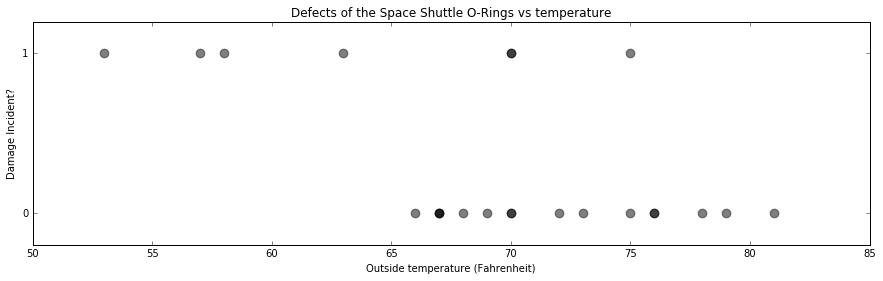

In [3]:
# GET THE DATA
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data_mcmc_1/challenger_data.csv", skip_header=1, usecols=[1, 2], missing_values="NA", delimiter=",")
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

# PLOT THE DATA
figsize(15, 4)
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?") ; plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature") ;

![](slides_mcmc_1/slides-4.png)

![](slides_mcmc_1/slides-46.png)

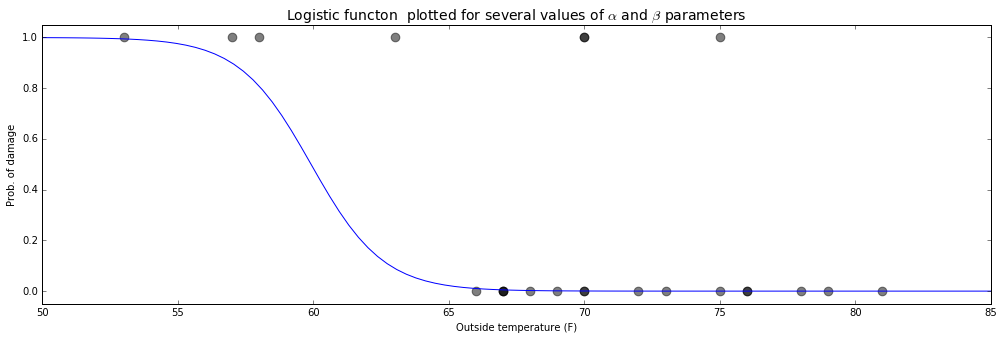

In [4]:
# TRY DIFFERENT PARAMETERS (alpha,beta) 
# => IT IS IMPORTANT TO ESTIMATE (alpha,beta), RIGHT ???
def logistic(x, beta, alpha=0): 
    eta = np.dot(beta, x) + alpha
    return np.exp(eta)/(1.0 + np.exp(eta))
def test_logistic(alpha, beta) :
    x = np.linspace(50, 85, 100)
    figsize(17, 5)
    plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k", alpha=0.5)
    plt.plot(x, logistic(x, beta, alpha))
    plt.title("Logistic functon  plotted for several values of $\\alpha$ and $\\beta$ parameters", fontsize=14)
    plt.ylabel("Prob. of damage"); plt.xlabel("Outside temperature (F)")
    plt.axis([50, 85, -0.05, 1.05])
interactive(test_logistic, alpha=(30.0,60.0,0.5), beta=(-1.5,-0.0,0.001))

In [5]:
# CALCULATE THE JOINT POSTERIOR DENSITY
# ... UP TO AN UNKNOW NORMALISING CONSTANT
# ... IN LOG SCALE (FOR COMPUTATIONAL STABILITY)

def LogPostPDF(alpha_value, beta_value, mydata) :
    # Prior hyperparameters
    sig2_alpha_prior = (1000.0)**2
    sig2_beta_prior = (1000.0)**2
    # data
    y = mydata[:,1].flatten(0)
    t = mydata[:,0].flatten(0)
    # link function
    eta = alpha_value+beta_value*t
    # compute the log-posterior-density
    # ... up to an unknown normalising constant
    try:
        thevalue = np.sum(eta*y - np.log(1+np.exp(eta))) \
                    -alpha_value**2/sig2_alpha_prior \
                    -beta_value**2/sig2_beta_prior
    except:
        logpdf = -float("inf")
    else:
        logpdf = thevalue
    return logpdf

![](slides_mcmc_1/slides-5.png)

![](slides_mcmc_1/slides-6.png)

![](slides_mcmc_1/slides-7.png)

![](slides_mcmc_1/slides-47.png)

![](slides_mcmc_1/slides-8.png)

![](slides_mcmc_1/slides-9.png)

![](slides_mcmc_1/slides-10.png)

![](slides_mcmc_1/slides-11.png)

![](slides_mcmc_1/slides-12.png)

![](slides_mcmc_1/slides-13.png)

![](slides_mcmc_1/slides-14.png)

![](slides_mcmc_1/slides-15.png)

![](slides_mcmc_1/slides-16.png)

# Bayesian inference by using a well designed MCMC sampler 

+ We use the pyMC module of Python package.

+ pyMC often designs a black-box satisfactory MCMC sampler


In [154]:
# FOR THE PYMC MODULE ONLY (!!!!) [OPTIONAL]

# DEFINE THE BAYESIAN MODEL

# PRIORS
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)

# LIKELIHOOD
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    eta = beta * t + alpha
    return np.exp(eta) / (1. + np.exp(eta))

# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

# DEFINE THE BAYESIAN HIERARHICAL MODEL
model = pm.Model([observed, beta, alpha])

# GET THE MCMC SAMPLE

N_iter = 100000
mcmc = pm.MCMC(model)
mcmc.sample(N_iter)
mcmc_sample = np.zeros((2,N_iter))
mcmc_sample[0,:] = mcmc.trace('alpha')[:, None].copy().flatten(1)
mcmc_sample[1,:] = mcmc.trace('beta')[:, None].copy().flatten(1)

alpha_sample = mcmc_sample[0,:][:, None]
beta_sample = mcmc_sample[1,:][:, None]
Pr66_sample = logistic(66.0,  beta_sample  , alpha_sample  ).flatten(1)

print "\n"
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

 [-----------------100%-----------------] 100000 of 100000 complete in 6.8 sec

Integrated autocorrelation time for alpha          : 2864.43183027
Integrated autocorrelation time for beta           : 2813.11330316
Integrated autocorrelation time for Pr(t=66.0|data): 10.0582597244


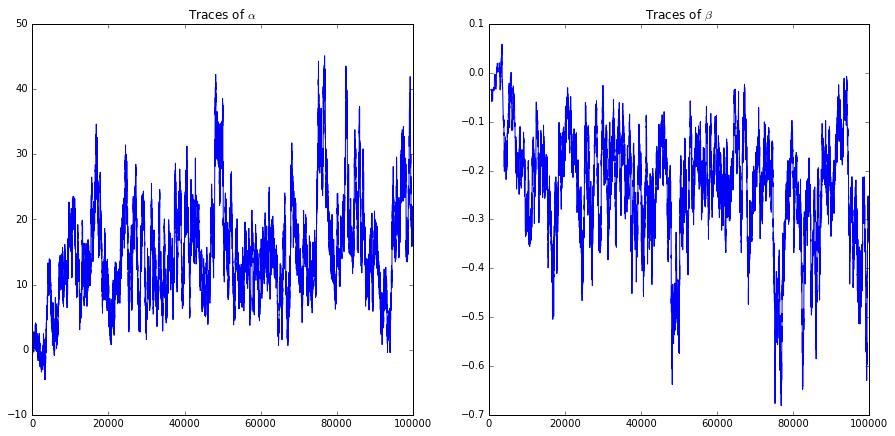

In [138]:
# TRACE PLOTS OF THE SAMPLE [OPTIONAL]
figsize(15, 7)
plt.subplot(121)
plt.plot(alpha_sample)
plt.title("Traces of $\\alpha$")
plt.subplot(122)
plt.plot(beta_sample)
plt.title("Traces of $\\beta$");

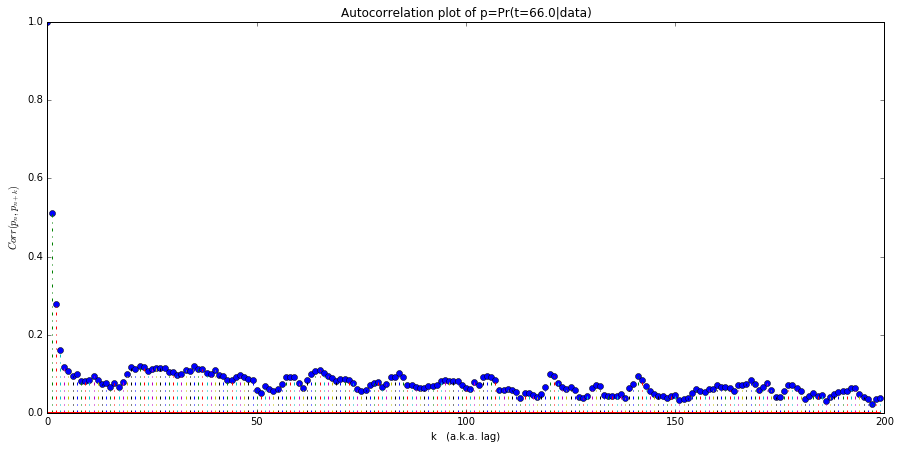

In [155]:
# AUTOCORRELATION OF ESTIMATED Pr(66.0)[OPTIONAL]
yy = myacorr(Pr66_sample[-5000:]) 
figsize(15,7)
markerline, stemlines, baseline = plt.stem( yy[:200], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of p=Pr(t=66.0|data)")
plt.xlabel("k   (a.k.a. lag)") ; plt.ylabel("$Corr(p_n,p_{n+k})$");

In [143]:
# POINT ESTIMATES OF UNKNOWN PRAMETERS

alpha_est = np.mean(alpha_sample)
alpha_se = np.sqrt(np.var(alpha_sample)*iat(alpha_sample)[0]/alpha_sample.size)

beta_est = np.mean(beta_sample)
beta_se = np.sqrt(np.var(beta_sample)*iat(beta_sample)[0]/beta_sample.size)

Pr66_est = np.mean(Pr66_sample)
Pr66_se = np.sqrt(np.var(Pr66_sample)*iat(Pr66_sample)[0]/Pr66_sample.size)

print 'Point estimate for alpha:', alpha_est 
print "Standard error for alpha:", alpha_se 
print " "
print "Point estimate for beta:", beta_est 
print "Standard error for beta:", beta_se
print " "
print "Point estimate for Pr(t=66.0|data):", Pr66_est 
print "Standard error for Pr(t=66.0|data):", Pr66_se

Point estimate for alpha: 14.8137601561
Standard error for alpha: 1.13538576701
 
Point estimate for beta: -0.229705738459
Standard error for beta: 0.016682327872
 
Point estimate for Pr(t=66.0|data): 0.420494818041
Standard error for Pr(t=66.0|data): 0.00123984886295


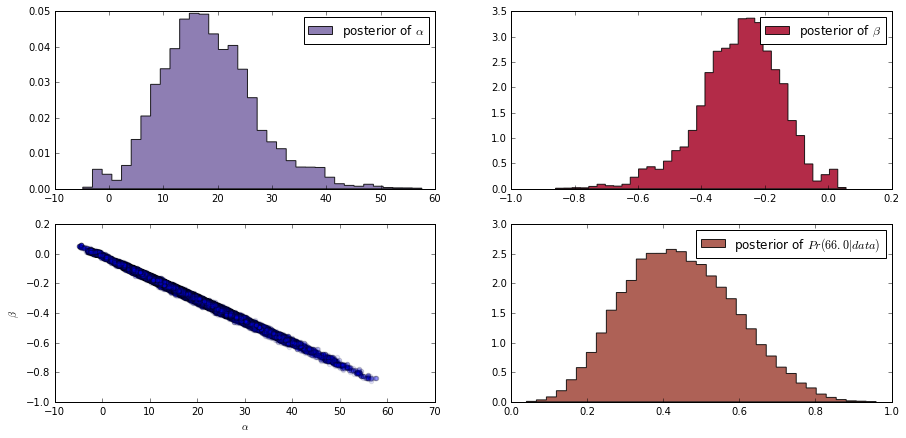

In [13]:
# PLOT THE MARGINAL POSTERIOR DENSITY 
figsize(15, 7)
plt.subplot(221)
plt.hist(alpha_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\alpha$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(222)
plt.hist(beta_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\beta$", color="#A60628", normed=True) 
plt.legend()
plt.subplot(223)
plt.scatter(alpha_sample, beta_sample, alpha=0.1); plt.xlabel(r"$\alpha$"); 
plt.ylabel(r"$\beta$"); 
plt.subplot(224)
plt.hist(Pr66_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $Pr(66.0|data)$", color="#A04538", normed=True)
plt.legend();

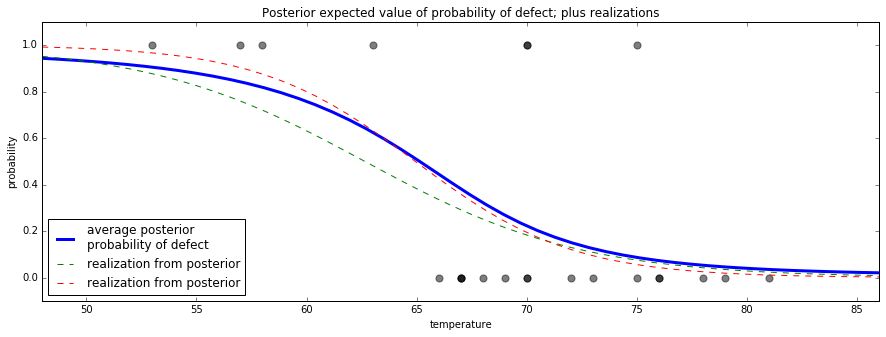

In [21]:
# PLOT THE PREDICTIONS

t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_sample, alpha_sample)
mean_prob_t = p_t.mean(axis=0)

figsize(15, 5)
plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability of defect")
plt.plot(t, p_t[-1000, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-5000, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1) ; plt.xlim(t.min(), t.max())
plt.ylabel("probability"); plt.xlabel("temperature");
plt.show()

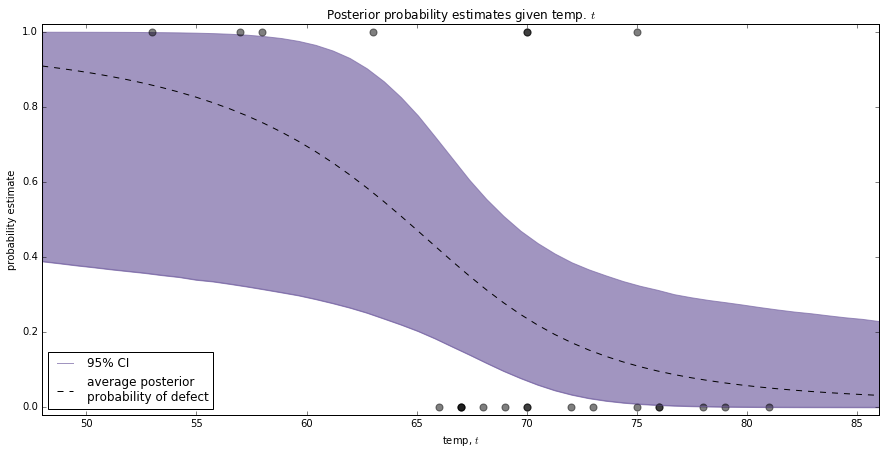

In [144]:
# PLOT THE PREDICTIONS WITH 95% PREDICTIVE INTERVALS
from scipy.stats.mstats import mquantiles
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_sample, alpha_sample)
mean_prob_t = p_t.mean(axis=0)
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
figsize(15, 7)
plt.fill_between(t[:, 0], *qs, alpha=0.7,color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k", label="average posterior \nprobability of defect")
plt.xlim(t.min(), t.max()); plt.ylim(-0.02, 1.02); plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$"); plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

# How to design our own MCMC sampler?

![](slides_mcmc_1/slides-18.png)

![](slides_mcmc_1/slides-19.png)

![](slides_mcmc_1/slides-20.png)

![](slides_mcmc_1/slides-21.png)

![](slides_mcmc_1/slides-22.png)

![](slides_mcmc_1/slides-23.png)

![](slides_mcmc_1/slides-24.png)

![](slides_mcmc_1/slides-25.png)

![](slides_mcmc_1/slides-26.png)

![](slides_mcmc_1/slides-27.png)

![](slides_mcmc_1/slides-28.png)

![](slides_mcmc_1/slides-29.png)

![](slides_mcmc_1/slides-30.png)

## Application: Random Walk Metropolis algorithm

In [145]:
# #################################################
# RUN THE RWM AND UPDATE SIMULTANEUSLY (apha, beta)
# #################################################

# #################################################
# SAMPLER:
# SET A SEED X_0 = (A_0,B_0)
# FOR T=1,...N
#     X_{T+1}  ~ P_{SCL}( X_{T} , d .)
# #################################################

# #################################################
# SAMPLER:
# SET A SEED X_0 = (A_0,B_0)
# FOR T=1,...N
#     1. PROPOSE X' ~ N( X_T , DIAG(SCL SCL)
#     2. COMPUTE ACCEPTANCE PROBABILITY A(X_T,X')
#     3. ACCEPT OR REJECT
# #################################################

# set number of iterations
N_iter = 100000
mcmc_sample = np.zeros((2,N_iter))

# set the seeds for (apha, beta)
alpha_now = 20.0
beta_now = -0.3

# set the scale of the RWM proposal
scl = 0.1
# scl_alpha = 0.1
# scl_beta = 0.5

# accprob_counter
acc_est = 0.0 ;
it = 0

# generate the iterations
# for iter=1:N_iter, sample x_{iter} ~ P( x_{iter} , d . )

for iter in range(0,N_iter) :
    
    # SIMULATE FROM THE RWM TRANSITION PROBABILITY
    
    # Generate the proposed values

    alpha_prop = alpha_now +scl*np.random.normal(0, 1)
    beta_prop = beta_now +scl*np.random.normal(0, 1)
    # alpha_prop = alpha_now +scl_alpha*np.random.normal(0, 1)
    # beta_prop = beta_now +scl_beta*np.random.normal(0, 1)
    
    # Compute the acceptance probability
    
    pdf_now = np.exp(LogPostPDF(alpha_now, beta_now, challenger_data))
    pdf_prop = np.exp(LogPostPDF(alpha_prop, beta_prop, challenger_data))
    
    acc_prob = min( 1.0, pdf_prop/pdf_now ) # better compute it in log scale...
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        mcmc_sample[0,iter] = alpha_prop
        mcmc_sample[1,iter] = beta_prop
        alpha_now = alpha_prop
        beta_now = beta_prop
    else:
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_now
        
    # Counter
    it = it+1
    acc_est = (acc_est*(it-1)+acc_prob)/float(it)
#

alpha_sample = mcmc_sample[0,:][:, None]
beta_sample = mcmc_sample[1,:][:, None]
Pr66_sample = logistic(66.0,  beta_sample  , alpha_sample  ).flatten(1)

print "Estimated acceptance ptobability                   :", acc_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

Estimated acceptance ptobability                   : 0.111167887743
Integrated autocorrelation time for alpha          : 15378.2464318
Integrated autocorrelation time for beta           : 472.807591703
Integrated autocorrelation time for Pr(t=66.0|data): 14.5079312646


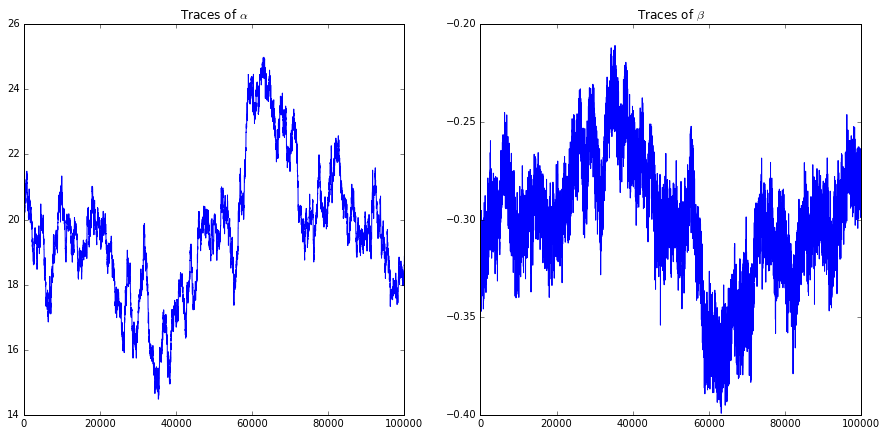

In [146]:
# TRACE PLOTS OF THE SAMPLE
figsize(15, 7)
plt.subplot(121)
plt.plot(alpha_sample)
plt.title("Traces of $\\alpha$")
plt.subplot(122)
plt.plot(beta_sample)
plt.title("Traces of $\\beta$");

In [147]:
print "\n\n"
print "Estimated acceptance ptobability                   :", acc_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]




Estimated acceptance ptobability                   : 0.111167887743
Integrated autocorrelation time for alpha          : 15378.2464318
Integrated autocorrelation time for beta           : 472.807591703
Integrated autocorrelation time for Pr(t=66.0|data): 14.5079312646


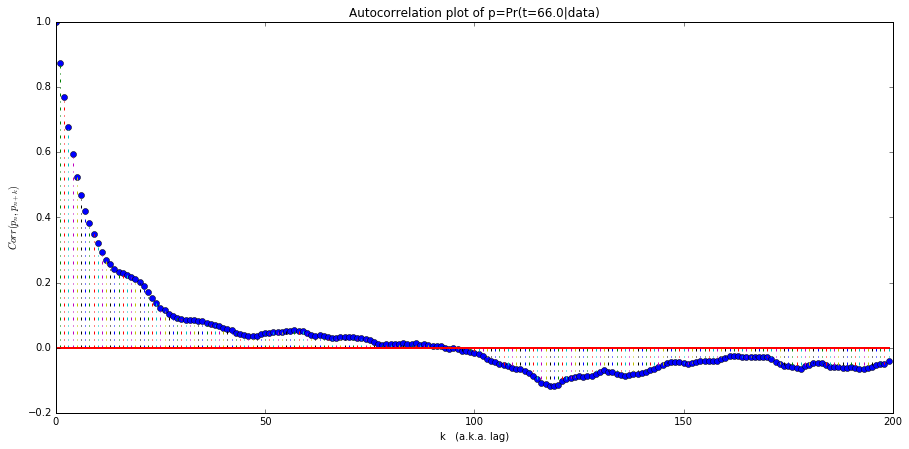

In [151]:
# AUTOCORRELATION OF ESTIMATED Pr(66.0)
yy = myacorr(Pr66_sample[-5000:])
figsize(15,7)
markerline, stemlines, baseline = plt.stem( yy[:200], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of p=Pr(t=66.0|data)")
plt.xlabel("k   (a.k.a. lag)") ; plt.ylabel("$Corr(p_n,p_{n+k})$");

In [80]:
# POINT ESTIMATES OF UNKNOWN PRAMETERS

alpha_est = np.mean(alpha_sample)
alpha_se = np.sqrt(np.var(alpha_sample)*iat(alpha_sample)[0]/alpha_sample.size)

beta_est = np.mean(beta_sample)
beta_se = np.sqrt(np.var(beta_sample)*iat(beta_sample)[0]/beta_sample.size)

Pr66_est = np.mean(Pr66_sample)
Pr66_se = np.sqrt(np.var(Pr66_sample)*iat(Pr66_sample)[0]/Pr66_sample.size)

print 'Point estimate for alpha:', alpha_est 
print "Standard error for alpha:", alpha_se 
print " "
print "Point estimate for beta:", beta_est 
print "Standard error for beta:", beta_se
print " "
print "Point estimate for Pr(t=66.0|data):", Pr66_est 
print "Standard error for betPr(t=66.0|data):", Pr66_se

Point estimate for alpha: 21.8118884583
Standard error for alpha: 1.17021882978
 
Point estimate for beta: -0.33213715737
Standard error for beta: 0.00348527981817
 
Point estimate for Pr(t=66.0|data): 0.475550904304
Standard error for betPr(t=66.0|data): 0.00164957324286


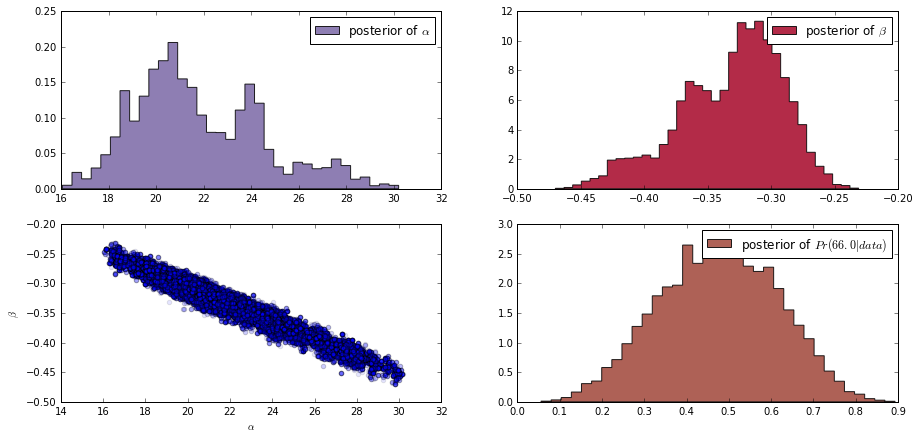

In [81]:
# PLOT THE MARGINAL POSTERIOR DENSITY 
figsize(15, 7)
plt.subplot(221)
plt.hist(alpha_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\alpha$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(222)
plt.hist(beta_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\beta$", color="#A60628", normed=True) 
plt.legend()
plt.subplot(223)
plt.scatter(alpha_sample, beta_sample, alpha=0.1); plt.xlabel(r"$\alpha$"); 
plt.ylabel(r"$\beta$"); 
plt.subplot(224)
plt.hist(Pr66_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $Pr(66.0|data)$", color="#A04538", normed=True)
plt.legend();

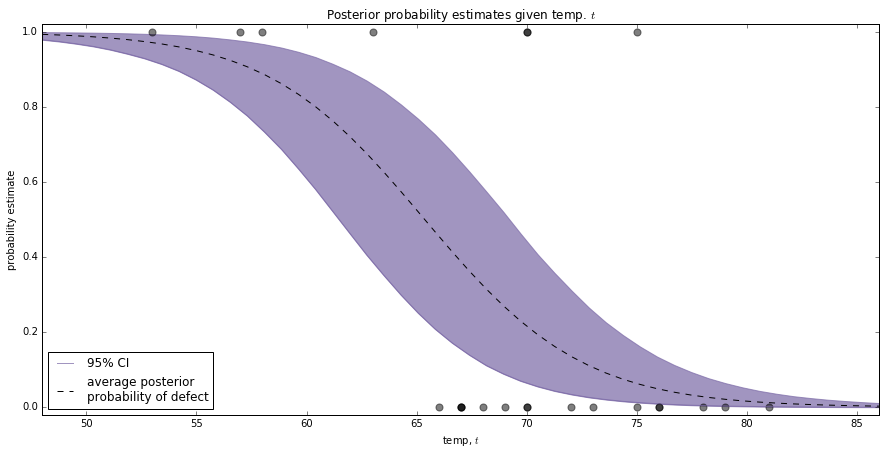

In [152]:
# PLOT THE PREDICTIONS WITH 95% PREDICTIVE INTERVALS
from scipy.stats.mstats import mquantiles
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_sample, alpha_sample)
mean_prob_t = p_t.mean(axis=0)
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
figsize(15, 7)
plt.fill_between(t[:, 0], *qs, alpha=0.7,color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k", label="average posterior \nprobability of defect")
plt.xlim(t.min(), t.max()); plt.ylim(-0.02, 1.02); plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$"); plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

## Can I tune (adjust) the proposals in any of those  Metropolis-Hastings algorithms?

![](slides_mcmc_1/slides-32.png)

![](slides_mcmc_1/slides-33.png)

![](slides_mcmc_1/slides-34.png)

![](slides_mcmc_1/slides-35.png)

## Application: Adaptive random Walk Metropolis algorithm

In [94]:
# #################################################
# RUN THE ADAPTIVE RWM : 
#     UPDATE SIMULTANEUSLY (apha, beta)
#     ADJUST SCL
# #################################################

# #################################################
# SAMPLER:
# SET A SEED X_0 = (A_0,B_0)
# FOR T=1,...N
#     SAMPLE: X_{T+1}  ~ P_{SCL}( X_{T} , d .)
#     ADJUST: SCL VIA STOCHASTIC APPROXIMATION
# #################################################

# #################################################
# SAMPLER:
# SET A SEED X_0 = (A_0,B_0)
# FOR T=1,...N
#     SAMPLE: 
#     1. PROPOSE X' ~ N( X_T , DIAG(SCL SCL)
#     2. COMPUTE ACCEPTANCE PROBABILITY A(X_T,X')
#     3. ACCEPT OR REJECT
#     ADJUST:
#     1. LOG(SCL) <- LOG(SCL) + GT*(A(X_T,X')-A_OPT)
# #################################################

# set number of iterations
N_iter = 100000
mcmc_sample = np.zeros((2,N_iter))

# set the seeds for (apha, beta)
alpha_now = 20.0
beta_now = -0.3

# set the scale of the RWM proposal
scl = 0.1

# optimal acceptance prob.
a_opt = 0.234

# gain sequence
def gain(t) :
    C = 1.0
    S = 0.6
    gt = C / ((1.0*t)**S)
    return gt

# accprob_counter
acc_est = 0.0 ;
it = 0

# generate the iterations
# for iter=1:N_iter, sample x_{iter} ~ P( x_{iter} , d . )

for iter in range(0,N_iter) :
    
    # SIMULATE FROM THE RWM TRANSITION PROBABILITY
    
    # Generate the proposed values
  
    alpha_prop = alpha_now +scl*np.random.normal(0, 1)
    beta_prop = beta_now +scl*np.random.normal(0, 1)
    
    # Compute the acceptance probability
    
    pdf_now = np.exp(LogPostPDF(alpha_now, beta_now, challenger_data))
    pdf_prop = np.exp(LogPostPDF(alpha_prop, beta_prop, challenger_data))

    acc_prob = min( 1.0, pdf_prop/pdf_now ) # better compute it in log scale...
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        mcmc_sample[0,iter] = alpha_prop
        mcmc_sample[1,iter] = beta_prop
        alpha_now = alpha_prop
        beta_now = beta_prop
    else :
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_now
    
    # Adapt
    
    it = it+1
    scl = scl * np.exp( gain(it+1.0) * (acc_prob-a_opt) )
 
    # Counter
    acc_est = (acc_est*(it-1)+acc_prob)/float(it)
#

alpha_sample = mcmc_sample[0,:][:, None]
beta_sample = mcmc_sample[1,:][:, None]
Pr66_sample = logistic(66.0,  beta_sample  , alpha_sample  ).flatten(1)

print "Estimated acceptance ptobability                   :", acc_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

print "Optimal scale                                      :", scl

Estimated acceptance ptobability                   : 0.234464631573
Integrated autocorrelation time for alpha          : 18431.6068428
Integrated autocorrelation time for beta           : 242.572343981
Integrated autocorrelation time for Pr(t=66.0|data): 6.51136019313
Optimal scale                                      : 0.0488427749057


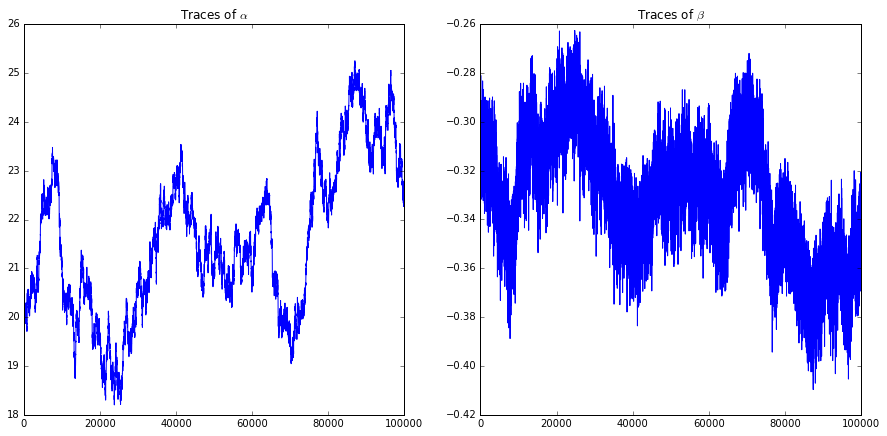

In [95]:
# TRACE PLOTS OF THE SAMPLE
figsize(15, 7)
plt.subplot(121)
plt.plot(alpha_sample)
plt.title("Traces of $\\alpha$")
plt.subplot(122)
plt.plot(beta_sample)
plt.title("Traces of $\\beta$");

In [96]:
print "Optimal scale                                      :", scl

print "Estimated acceptance ptobability                   :", acc_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

Optimal scale                                      : 0.0488427749057
Estimated acceptance ptobability                   : 0.234464631573
Integrated autocorrelation time for alpha          : 18431.6068428
Integrated autocorrelation time for beta           : 242.572343981
Integrated autocorrelation time for Pr(t=66.0|data): 6.51136019313


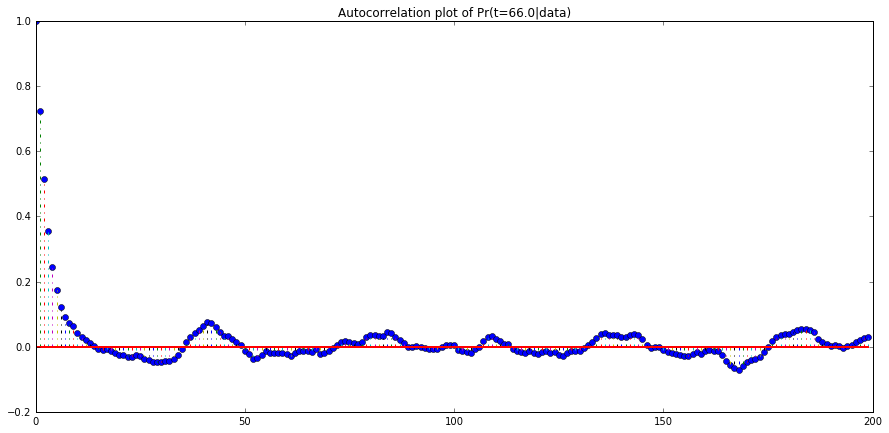

In [97]:
# AUTOCORRELATION OF ESTIMATED Pr(66.0)
yy = myacorr(Pr66_sample[-5000:])
figsize(15,7)
markerline, stemlines, baseline = plt.stem( yy[:200], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of Pr(t=66.0|data)");

In [98]:
# POINT ESTIMATES OF UNKNOWN PRAMETERS

alpha_est = np.mean(alpha_sample)
alpha_se = np.sqrt(np.var(alpha_sample)*iat(alpha_sample)[0]/alpha_sample.size)

beta_est = np.mean(beta_sample)
beta_se = np.sqrt(np.var(beta_sample)*iat(beta_sample)[0]/beta_sample.size)

Pr66_est = np.mean(Pr66_sample)
Pr66_se = np.sqrt(np.var(Pr66_sample)*iat(Pr66_sample)[0]/Pr66_sample.size)

print 'Point estimate for alpha:', alpha_est 
print "Standard error for alpha:", alpha_se 
print " "
print "Point estimate for beta:", beta_est 
print "Standard error for beta:", beta_se
print " "
print "Point estimate for Pr(t=66.0|data):", Pr66_est 
print "Standard error for betPr(t=66.0|data):", Pr66_se

Point estimate for alpha: 21.5685467864
Standard error for alpha: 0.667496604968
 
Point estimate for beta: -0.328792498128
Standard error for beta: 0.00120585516114
 
Point estimate for Pr(t=66.0|data): 0.470313267348
Standard error for betPr(t=66.0|data): 0.0011143629589


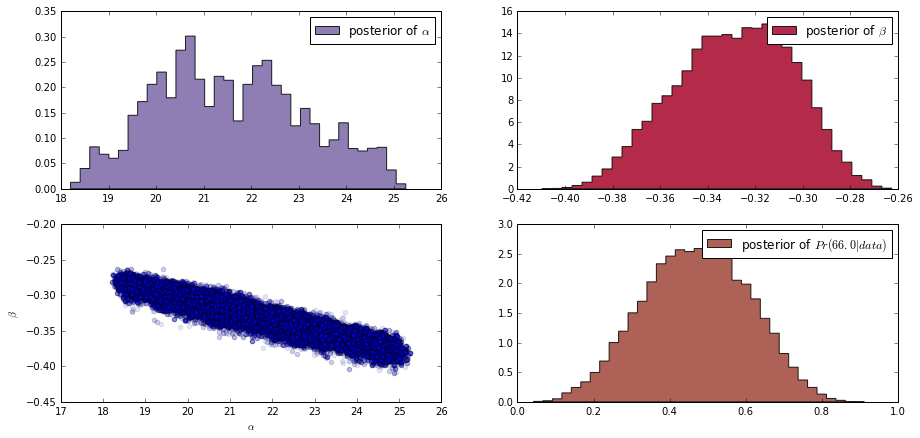

In [99]:
# PLOT THE MARGINAL POSTERIOR DENSITY 
figsize(15, 7)
plt.subplot(221)
plt.hist(alpha_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\alpha$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(222)
plt.hist(beta_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\beta$", color="#A60628", normed=True) 
plt.legend()
plt.subplot(223)
plt.scatter(alpha_sample, beta_sample, alpha=0.1); plt.xlabel(r"$\alpha$"); 
plt.ylabel(r"$\beta$"); 
plt.subplot(224)
plt.hist(Pr66_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $Pr(66.0|data)$", color="#A04538", normed=True)
plt.legend();

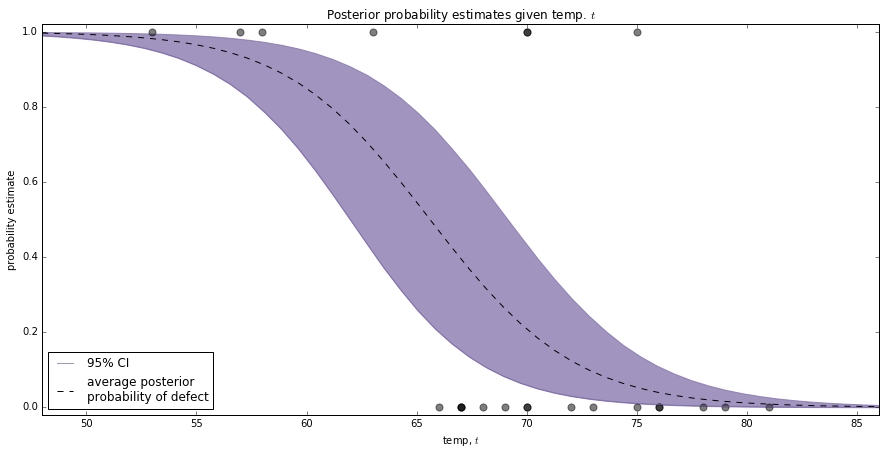

In [100]:
# PLOT THE PREDICTIONS WITH 95% PREDICTIVE INTERVALS
from scipy.stats.mstats import mquantiles
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_sample, alpha_sample)
mean_prob_t = p_t.mean(axis=0)
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
figsize(15, 7)
plt.fill_between(t[:, 0], *qs, alpha=0.7,color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k", label="average posterior \nprobability of defect")
plt.xlim(t.min(), t.max()); plt.ylim(-0.02, 1.02); plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$"); plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

## Blockwise MCMC samplers

... or otherwise combining MCMC transition probabilities

![](slides_mcmc_1/slides-37.png)

![](slides_mcmc_1/slides-38.png)

![](slides_mcmc_1/slides-39.png)

![](slides_mcmc_1/slides-40.png)

![](slides_mcmc_1/slides-42.png)

![](slides_mcmc_1/slides-43.png)

![](slides_mcmc_1/slides-44.png)

## Application: Blockwise MCMC with Random Walk Metropolis

In [1]:
# #################################################
# RUN THE BLOCKWISE RWM : 
#     UPDATE apha
#     UPDATE beta
# #################################################

# #################################################
# SAMPLER:
# SET A SEED X_0 = (A_0,B_0)
# FOR T=1,...N
#
#     BLOCK: UPDATE ALPHA
#     SAMPLE: X'=(A',B_{T})  ~ P_{SCL_A}^{ALPHA}( X_{T}=(A_{T},B_{T}) , d .) 
#
#     BLOCK: UPDATE BETA
#     SAMPLE: X''=(A',B')  ~ P_{SCL_B}^{BETA}( X'=(A',B_{T}) , d .)
# #################################################

# #################################################
#     BLOCK: UPDATE ALPHA
#
#     SAMPLE: 
#     1. PROPOSE X'=(A',B') S.T.  A'~ N( A_{T} , SCL_A) AND B' = B_{T}
#     2. COMPUTE ACCEPTANCE PROBABILITY A(X_T,X')
#     3. ACCEPT OR REJECT
# #################################################

# #################################################
#     BLOCK: UPDATE BETA
#
#     SAMPLE: 
#     1. PROPOSE X'=(A',B') S.T. A' = A_{T} AND B'~ N( B_{T} , SCL_B)
#     2. COMPUTE ACCEPTANCE PROBABILITY A(X_T,X')
#     3. ACCEPT OR REJECT
# #################################################

# set number of iterations
N_iter = 100000
mcmc_sample = np.zeros((2,N_iter))

# set the seeds for (apha, beta)
alpha_now = 10.0
beta_now = -0.3

# set the scale of the RWM proposal
scl_alpha = 0.1
scl_beta = 0.1

# accprob_counter
acc_alpha_est = 0.0 ;
acc_beta_est = 0.0 ;
it_alpha = 0
it_beta = 0

# generate the iterations
# for iter=1:N_iter, sample x_{iter} ~ P( x_{iter} , d . )

for iter in range(0,N_iter) :
    
    # SIMULATE FROM THE RWM TRANSITION PROBABILITY
    
    # ==================
    # BLOCK UPDATE ALPHA 
    # ==================

    # Generate the proposed values
    
    alpha_prop = alpha_now +scl_alpha*np.random.normal(0, 1)
    beta_prop = beta_now
    
    # Compute the acceptance probability
        
    pdf_now = np.exp(LogPostPDF(alpha_now, beta_now, challenger_data))
    pdf_prop = np.exp(LogPostPDF(alpha_prop, beta_prop, challenger_data))

    acc_prob = min( 1.0, pdf_prop/pdf_now ) # better compute it in log scale...
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        mcmc_sample[0,iter] = alpha_prop
        mcmc_sample[1,iter] = beta_now
        alpha_now = alpha_prop
        beta_now = beta_now
    else :
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_now
        
    # Counter
    it_alpha = it_alpha+1
    acc_alpha_est = (acc_alpha_est*(it_alpha-1)+acc_prob)/float(it_alpha)
    
    # ==================
    # BLOCK UPDATE BETA 
    # ==================
    
    # Generate the proposed values
    
    alpha_prop = alpha_now
    beta_prop = beta_now +scl_beta*np.random.normal(0, 1)
    
    # Compute the acceptance probability
    
    pdf_now = np.exp(LogPostPDF(alpha_now, beta_now, challenger_data))
    pdf_prop = np.exp(LogPostPDF(alpha_prop, beta_prop, challenger_data))

    acc_prob = min( 1.0, pdf_prop/pdf_now ) # better compute it in log scale...
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_prop
        alpha_now = alpha_prop
        beta_now = beta_prop
    else :
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_now
        
    # Counter
    it_beta = it_beta+1
    acc_beta_est = (acc_beta_est*(it_beta-1)+acc_prob)/float(it_beta)
    
#

alpha_sample = mcmc_sample[0,:][:, None]
beta_sample = mcmc_sample[1,:][:, None]
Pr66_sample = logistic(66.0,  beta_sample  , alpha_sample  ).flatten(1)

print "Estimated acceptance ptobability  (Block alpha)    :", acc_alpha_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Estimated acceptance ptobability  (Block beta)     :", acc_beta_est
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

NameError: name 'np' is not defined

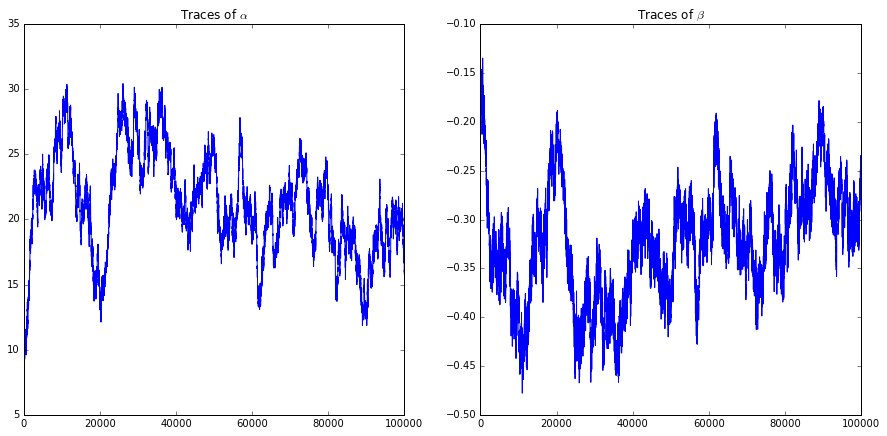

In [103]:
# TRACE PLOTS OF THE SAMPLE
figsize(15, 7)
plt.subplot(121)
plt.plot(alpha_sample)
plt.title("Traces of $\\alpha$")
plt.subplot(122)
plt.plot(beta_sample)
plt.title("Traces of $\\beta$");

In [104]:
print "Estimated acceptance ptobability  (Block alpha)    :", acc_alpha_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Estimated acceptance ptobability  (Block beta)     :", acc_beta_est
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

Estimated acceptance ptobability  (Block alpha)    : 0.947578976498
Integrated autocorrelation time for alpha          : 5976.38219894
Estimated acceptance ptobability  (Block beta)     : 0.113082929673
Integrated autocorrelation time for beta           : 1421.83633335
Integrated autocorrelation time for Pr(t=66.0|data): 14.3816325874


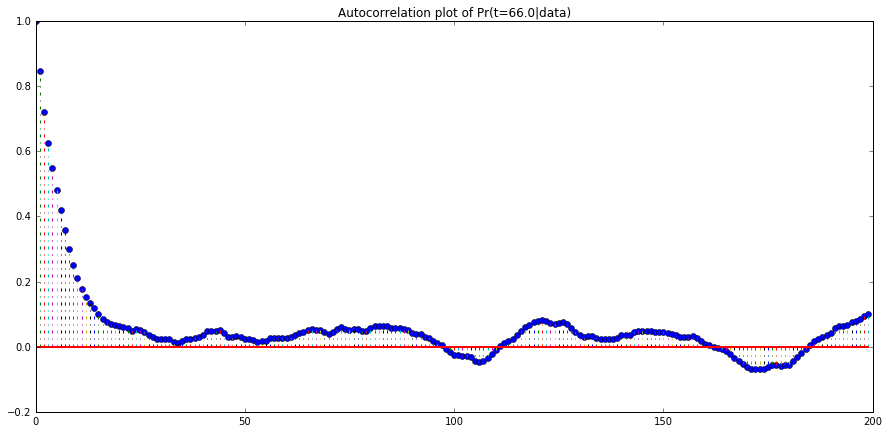

In [106]:
# AUTOCORRELATION OF ESTIMATED Pr(66.0)
yy = myacorr(Pr66_sample[-5000:])
figsize(15,7)
markerline, stemlines, baseline = plt.stem( yy[:200], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of Pr(t=66.0|data)");

In [107]:
# POINT ESTIMATES OF UNKNOWN PRAMETERS

alpha_est = np.mean(alpha_sample)
alpha_se = np.sqrt(np.var(alpha_sample)*iat(alpha_sample)[0]/alpha_sample.size)

beta_est = np.mean(beta_sample)
beta_se = np.sqrt(np.var(beta_sample)*iat(beta_sample)[0]/beta_sample.size)

Pr66_est = np.mean(Pr66_sample)
Pr66_se = np.sqrt(np.var(Pr66_sample)*iat(Pr66_sample)[0]/Pr66_sample.size)

print 'Point estimate for alpha:', alpha_est 
print "Standard error for alpha:", alpha_se 
print " "
print "Point estimate for beta:", beta_est 
print "Standard error for beta:", beta_se
print " "
print "Point estimate for Pr(t=66.0|data):", Pr66_est 
print "Standard error for betPr(t=66.0|data):", Pr66_se

Point estimate for alpha: 21.2215080861
Standard error for alpha: 0.951021106903
 
Point estimate for beta: -0.323574085969
Standard error for beta: 0.0068414684558
 
Point estimate for Pr(t=66.0|data): 0.469844807433
Standard error for betPr(t=66.0|data): 0.00169291168295


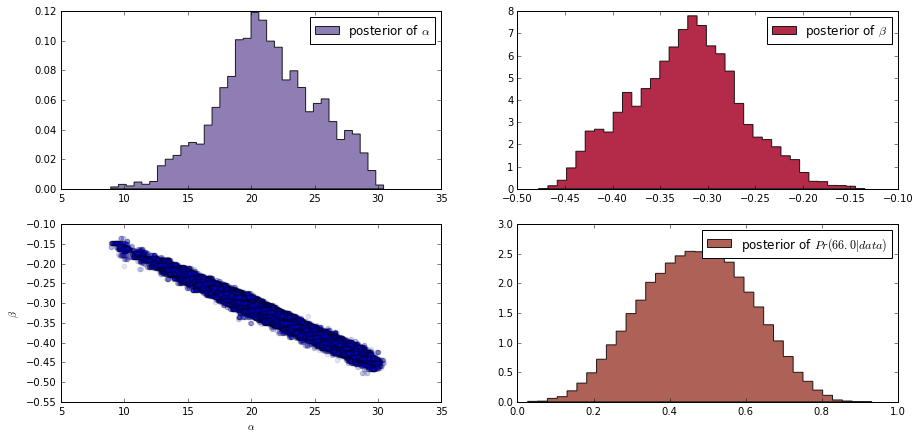

In [108]:
# PLOT THE MARGINAL POSTERIOR DENSITY 
figsize(15, 7)
plt.subplot(221)
plt.hist(alpha_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\alpha$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(222)
plt.hist(beta_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\beta$", color="#A60628", normed=True) 
plt.legend()
plt.subplot(223)
plt.scatter(alpha_sample, beta_sample, alpha=0.1); plt.xlabel(r"$\alpha$"); 
plt.ylabel(r"$\beta$"); 
plt.subplot(224)
plt.hist(Pr66_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $Pr(66.0|data)$", color="#A04538", normed=True)
plt.legend();

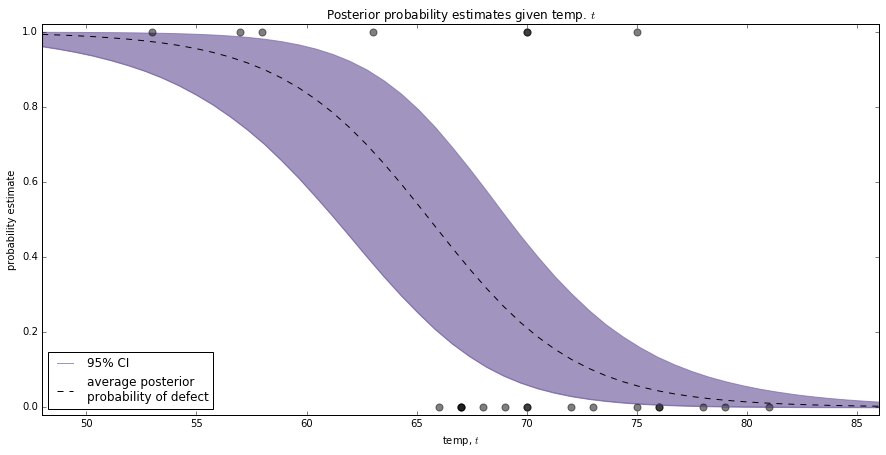

In [109]:
# PLOT THE PREDICTIONS WITH 95% PREDICTIVE INTERVALS
from scipy.stats.mstats import mquantiles
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_sample, alpha_sample)
mean_prob_t = p_t.mean(axis=0)
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
figsize(15, 7)
plt.fill_between(t[:, 0], *qs, alpha=0.7,color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k", label="average posterior \nprobability of defect")
plt.xlim(t.min(), t.max()); plt.ylim(-0.02, 1.02); plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$"); plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

## Application: Blockwise MCMC with adaptive Random Walk Metropolis

In [127]:
# #################################################
# RUN THE BLOCKWISE MCMC WITH ADAPTIVE RWM: 
# 
# BLOCK: UPDATE ALPHA
#     UPDATE apha
#     ADJUST SCL_A
# 
# BLOCK: UPDATE ALPHA
#     UPDATE beta
#     ADJUST SCL_B
# 
# #################################################

# #################################################
# SAMPLER:
# SET A SEED X_0 = (A_0,B_0)
# FOR T=1,...N
#
#     BLOCK: UPDATE ALPHA
#     SAMPLE: X'=(A',B_{T})  ~ P_{SCL_A}^{ALPHA}( X_{T}=(A_{T},B_{T}) , d .) 
#     ADJUST: SCL_A VIA STOCHASTIC APPROXIMATION
#
#     BLOCK: UPDATE BETA
#     SAMPLE: X''=(A',B')  ~ P_{SCL_B}^{BETA}( X'=(A',B_{T}) , d .)
#     ADJUST: SCL_B VIA STOCHASTIC APPROXIMATION
# #################################################

# #################################################
#     BLOCK: UPDATE ALPHA
#
#     SAMPLE: 
#     1. PROPOSE X'=(A',B') S.T.  A'~ N( A_{T} , SCL_A) AND B' = B_{T}
#     2. COMPUTE ACCEPTANCE PROBABILITY A(X_T,X')
#     3. ACCEPT OR REJECT
# #################################################

# #################################################
#     ADJUST:
#     1. LOG(SCL_A) <- LOG(SCL_A) + GT*(A(X_T,X')-A_OPT)
# #################################################

# #################################################
#     BLOCK: UPDATE BETA
#
#     SAMPLE: 
#     1. PROPOSE X'=(A',B') S.T. A' = A_{T} AND B'~ N( B_{T} , SCL_B)
#     2. COMPUTE ACCEPTANCE PROBABILITY A(X_T,X')
#     3. ACCEPT OR REJECT
# #################################################

# #################################################
#     ADJUST:
#     1. LOG(SCL_B) <- LOG(SCL_B) + GT*(A(X_T,X')-A_OPT)
# #################################################


# set number of iterations
N_iter = 100000
mcmc_sample = np.zeros((2,N_iter))

# set the seeds for (apha, beta)
alpha_now = 20.0
beta_now = -0.3

# set the scale of the RWM proposal
scl_alpha = 0.1
scl_beta = 0.1

# optimal acceptance prob.
a_opt = 0.234
it_alpha = 0 ;
it_beta = 0 ;

# gain sequence
def gain(t) :
    C = 1.0
    S = 0.6
    gt = C / ((1.0*t)**S)
    return gt

# accprob_counter
acc_alpha_est = 0.0 ;
acc_beta_est = 0.0 ;
it_alpha = 0
it_beta = 0

# generate the iterations
# for iter=1:N_iter, sample x_{iter} ~ P( x_{iter} , d . )

for iter in range(0,N_iter) :
    
    # SIMULATE FROM THE RWM TRANSITION PROBABILITY
    
    # ==================
    # BLOCK UPDATE ALPHA 
    # ==================
    
    # Generate the proposed values
    
    alpha_prop = alpha_now +scl_alpha*np.random.normal(0, 1)
    beta_prop = beta_now
    
    # Compute the acceptance probability
    
    pdf_now = np.exp(LogPostPDF(alpha_now, beta_now, challenger_data))
    pdf_prop = np.exp(LogPostPDF(alpha_prop, beta_prop, challenger_data))

    acc_prob = min( 1.0, pdf_prop/pdf_now ) # better compute it in log scale...
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        mcmc_sample[0,iter] = alpha_prop
        mcmc_sample[1,iter] = beta_now
        alpha_now = alpha_prop
        beta_now = beta_prop
    else :
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_now
    
    # Adapt scl_alpha
    
    it_alpha = it_alpha+1.0
    scl_alpha = scl_alpha * np.exp( gain(it_alpha+1) * (acc_prob-a_opt) )
    
    # Counter
    it_alpha = it_alpha+1
    acc_alpha_est = (acc_alpha_est*(it_alpha-1)+acc_prob)/float(it_alpha)
    
    # ==================
    # BLOCK UPDATE BETA 
    # ==================
    
    # Generate the proposed values
    
    alpha_prop = alpha_now
    beta_prop = beta_now +scl_beta*np.random.normal(0, 1)
    
    # Compute the acceptance probability
    
    pdf_now = np.exp(LogPostPDF(alpha_now, beta_now, challenger_data))
    pdf_prop = np.exp(LogPostPDF(alpha_prop, beta_prop, challenger_data))

    acc_prob = min( 1.0, pdf_prop/pdf_now ) # better compute it in log scale...
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_prop
        alpha_now = alpha_prop
        beta_now = beta_prop
    else :
        mcmc_sample[0,iter] = alpha_now
        mcmc_sample[1,iter] = beta_now
    
    # Adapt
    
    it_beta = it_beta+1.0
    scl_beta = scl_beta * np.exp( gain(it_beta+1) * (acc_prob-a_opt) )
    
    # Counter
    it_beta = it_beta+1
    acc_beta_est = (acc_beta_est*(it_beta-1)+acc_prob)/float(it_beta)
    
#
alpha_sample = mcmc_sample[0,:][:, None]
beta_sample = mcmc_sample[1,:][:, None]
Pr66_sample = logistic(66.0,  beta_sample  , alpha_sample  ).flatten(1)

print "Optimal scale  (Block alpha)                       :", scl_alpha
print "Optimal scale  (Block beta )                       :", scl_beta

print "Estimated acceptance ptobability  (Block alpha)    :", acc_alpha_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Estimated acceptance ptobability  (Block beta)     :", acc_beta_est
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

Optimal scale  (Block alpha)                       : 3.11556059033
Optimal scale  (Block beta )                       : 0.0458687480538
Estimated acceptance ptobability  (Block alpha)    : 0.244429531409
Integrated autocorrelation time for alpha          : 2364.69403492
Estimated acceptance ptobability  (Block beta)     : 0.231294489869
Integrated autocorrelation time for beta           : 2410.32502355
Integrated autocorrelation time for Pr(t=66.0|data): 8.71208324761


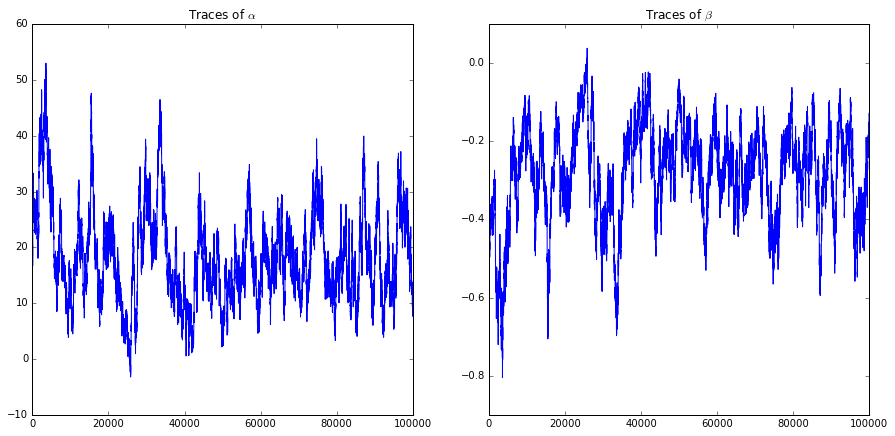

In [128]:
# TRACE PLOTS OF THE SAMPLE
figsize(15, 7)
plt.subplot(121)
plt.plot(alpha_sample)
plt.title("Traces of $\\alpha$")
plt.subplot(122)
plt.plot(beta_sample)
plt.title("Traces of $\\beta$");

In [130]:
print "Optimal scale  (Block alpha)                       :", scl_alpha
print "Optimal scale  (Block beta )                       :", scl_beta

print "Estimated acceptance ptobability  (Block alpha)    :", acc_alpha_est
print "Integrated autocorrelation time for alpha          :", iat(alpha_sample)[0]
print "Estimated acceptance ptobability  (Block beta)     :", acc_beta_est
print "Integrated autocorrelation time for beta           :", iat(beta_sample)[0]
print "Integrated autocorrelation time for Pr(t=66.0|data):", iat(Pr66_sample)[0]

Optimal scale  (Block alpha)                       : 3.11556059033
Optimal scale  (Block beta )                       : 0.0458687480538
Estimated acceptance ptobability  (Block alpha)    : 0.244429531409
Integrated autocorrelation time for alpha          : 2364.69403492
Estimated acceptance ptobability  (Block beta)     : 0.231294489869
Integrated autocorrelation time for beta           : 2410.32502355
Integrated autocorrelation time for Pr(t=66.0|data): 8.71208324761


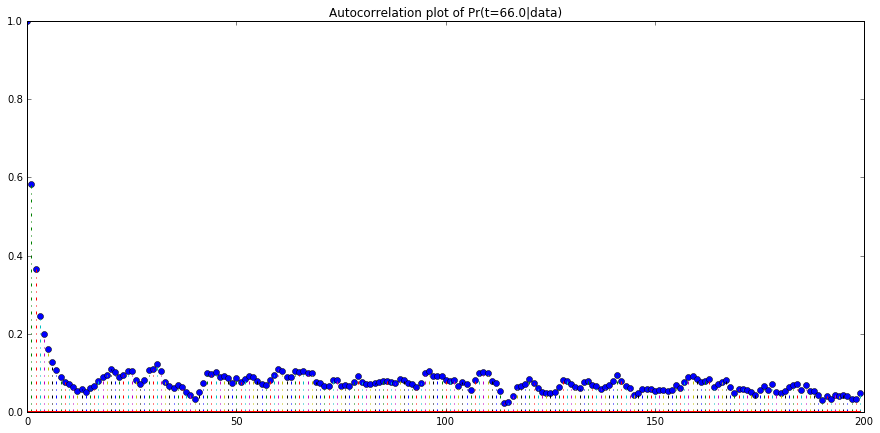

In [131]:
# AUTOCORRELATION OF ESTIMATED Pr(66.0)
yy = myacorr(Pr66_sample[-5000:])
figsize(15,7)
markerline, stemlines, baseline = plt.stem( yy[:200], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of Pr(t=66.0|data)");

In [132]:
# POINT ESTIMATES OF UNKNOWN PRAMETERS

alpha_est = np.mean(alpha_sample)
alpha_se = np.sqrt(np.var(alpha_sample)*iat(alpha_sample)[0]/alpha_sample.size)

beta_est = np.mean(beta_sample)
beta_se = np.sqrt(np.var(beta_sample)*iat(beta_sample)[0]/beta_sample.size)

Pr66_est = np.mean(Pr66_sample)
Pr66_se = np.sqrt(np.var(Pr66_sample)*iat(Pr66_sample)[0]/Pr66_sample.size)

print 'Point estimate for alpha:', alpha_est 
print "Standard error for alpha:", alpha_se 
print " "
print "Point estimate for beta:", beta_est 
print "Standard error for beta:", beta_se
print " "
print "Point estimate for Pr(t=66.0|data):", Pr66_est 
print "Standard error for betPr(t=66.0|data):", Pr66_se

Point estimate for alpha: 18.2340313286
Standard error for alpha: 1.28482767257
 
Point estimate for beta: -0.279884463964
Standard error for beta: 0.0190451946187
 
Point estimate for Pr(t=66.0|data): 0.445316517217
Standard error for betPr(t=66.0|data): 0.00135370090818


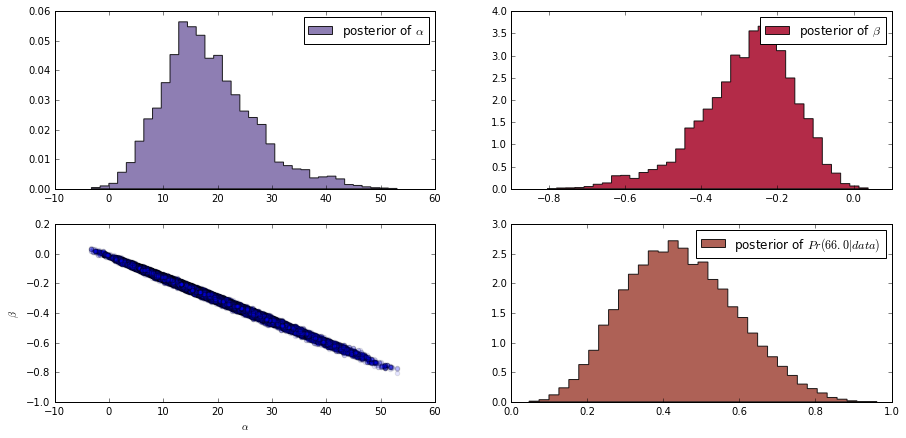

In [133]:
# PLOT THE MARGINAL POSTERIOR DENSITY 
figsize(15, 7)
plt.subplot(221)
plt.hist(alpha_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\alpha$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(222)
plt.hist(beta_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $\beta$", color="#A60628", normed=True) 
plt.legend()
plt.subplot(223)
plt.scatter(alpha_sample, beta_sample, alpha=0.1); plt.xlabel(r"$\alpha$"); 
plt.ylabel(r"$\beta$"); 
plt.subplot(224)
plt.hist(Pr66_sample, histtype='stepfilled', bins=35, alpha=0.85, label=r"posterior of $Pr(66.0|data)$", color="#A04538", normed=True)
plt.legend();

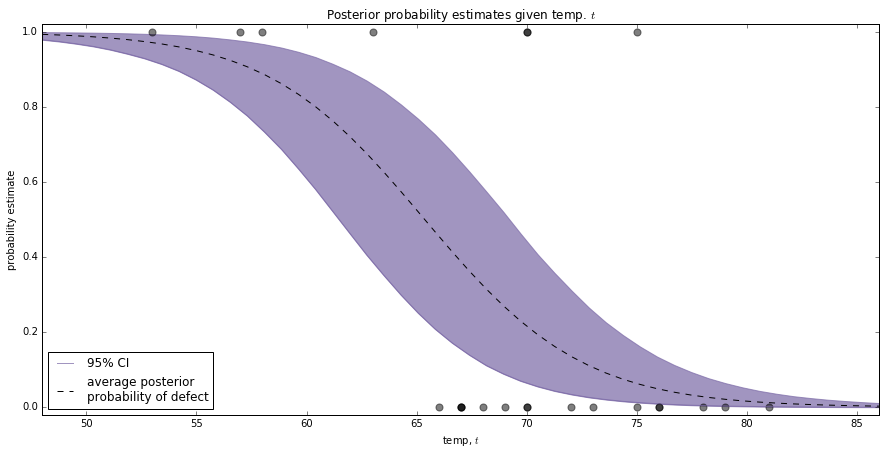

In [153]:
# PLOT THE PREDICTIONS WITH 95% PREDICTIVE INTERVALS
from scipy.stats.mstats import mquantiles
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_sample, alpha_sample)
mean_prob_t = p_t.mean(axis=0)
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
figsize(15, 7)
plt.fill_between(t[:, 0], *qs, alpha=0.7,color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k", label="average posterior \nprobability of defect")
plt.xlim(t.min(), t.max()); plt.ylim(-0.02, 1.02); plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$"); plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

## How to improve the MCMC sample?

![](slides_mcmc_1/slides-45.png)

## Blockwise MCMC with adaptive MALA 

Practice

Steps:

1. Calculate the gradient of the log posterior distribution, and write a function 
2. Modify the sampler in Section "Blockwise MCMC with adaptive RWM"
    1. Change the proposals, acceptance probability, optimal a_opt, etc
    
Question:
    1. Does MALA work better than RWM ??

In [42]:
# Notes: 

# The gradient ( log(pi(a,b|data)) ) routine

def gradPr_exact(a ,b, mydata) :
    sig2_alpha_prior = (1000.0)**2
    sig2_beta_prior = (1000.0)**2
    y = mydata[:,1].flatten(0)
    t = mydata[:,0].flatten(0)
    dlogpi_a = np.sum( y - np.exp(a+b*t)/(1+np.exp(a+b*t)) ) -a/sig2_alpha_prior
    dlogpi_b = np.sum( y*t - np.exp(a+b*t)/(1+np.exp(a+b*t))*t ) -b/sig2_beta_prior
    return (dlogpi_a,dlogpi_b)

#     Here is an approx. but NOT efficient routine to do this:

def gradPr_approx(a ,b, model) :
    myeps = 8.9406967163085938e-08
    f_2 = np.exp(LogPostPDF(a+myeps/2.0, b, model))
    f_1 = np.exp(LogPostPDF(a-myeps/2.0, b, model))
    dlogpi_a = (f_2-f_1) / myeps
    f_2 = np.exp(LogPostPDF(a, b+myeps/2.0, model))
    f_1 = np.exp(LogPostPDF(a, b-myeps/2.0, model))
    dlogpi_b = (d2-d1) / myeps
    return (dlogpi_a,dlogpi_b)

    
